In [52]:
import pandas as pd
import numpy as np
import time
import os
import sys
from itertools import islice
from collections import defaultdict
import pickle
from __future__ import division
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import json
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import euclidean_distances
import re
from collections import Counter
from tslearn.utils import to_time_series_dataset
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

os.environ["OMP_NUM_THREADS"] = '1'
sys.path.append(os.path.abspath("./src/"))

import backbone_construction
import backbone_time_series
import backbone_update
import cell_state_paths_construction
import utils
import visualization_GAM_plots
from backbone_construction import InitialBackboneConstruction
from cell_state_paths_construction import CellStatePathConstructor
from backbone_time_series import InitialBackboneTimeSeries
from backbone_update import TimeSeriesDTWMatch 

## TimeFlow 2 
* [Data loading](#data_loading)
* [Lineage detection](#module1)
    * [Steps 1-2](#step_1_step_2)
        * [Pseudotime segmentation and cell states clustering](#pseudotime_and_GMM)
    * [Step 3](#step_3)
        * [Cell state paths](#paths)
    * [Step 4](#step_4)
        * [Intra-segment 2-Wasserstein distances](#wasserstein)
        * [Path costs](#path_costs)
        * [Path grouping](#path_grouping)
    * [Step 5](#step_5)
        * [Leaf clusters](#leaf_clusters)
        * [Leaf absorption (by Pearson correlation)](#pearson)
        * [Leaf absorption (by Dynamic Time Warping)](#DTW)
        * [Pathway refinement](#refinement)    
* [Marker dynamics and lineage extraction](#markers_GAM_models)
* [Saving Metadata](#output)
* [Evaluation](#evaluation)

## Data loading <a class="anchor" id="data_loading"></a>

In this step we load the flow cytometry dataset (CSV file). Features correspond to all cytometry markers and pseudotime (as estimated by [TimeFlow](https://github.com/MargaritaLiarou1/TimeFlow)). 

In [4]:
df = pd.read_csv("./datasets/P1_BM_pseudotime.csv")

print(df.shape)
print("Dataset columns: ", df.columns)

(499544, 22)
Dataset columns:  Index(['CD200', 'CD14', 'CD45', 'CD45RA', 'CD64', 'CD3', 'CD15', 'CD133',
       'CD117', 'CD56', 'HLA.DR', 'CD19', 'CD33', 'CD34', 'CD371', 'CD7',
       'CD16', 'CD123', 'CD36', 'CD38', 'Celltype', 'pseudotime'],
      dtype='object')


In [5]:
# keep only numeric columns and drop 'pseudotime' column 
df = df.drop(["Celltype"], axis=1)
print(df.shape)

(499544, 21)


## Cell Lineage Detection <a class="anchor" id="module1"></a>

### Steps 1 & 2 <a class="anchor" id="step_1_step_2"></a>

### Pseudotime segmentation and cell states clustering <a id="pseudotime_and_GMM"></a>
We segment the pseudotime axis in ten equal-width segments with 35% width overlap and create clusters (cell states) within each segment using the Gaussian Mixture Model (GMM). We set the maximum number of clusters within each segment to 25 and use the BIC criterion to select the final number. We have tested these hyper-parameters for datasets above 150,000 cells.

In [14]:
# cell states paths with default parameters (for large datasets with more than 150,000 cells)

cell_state_path_costructor = cell_state_paths_construction.CellStatePathConstructor(df, pseudotime_col='pseudotime',
                                                                               num_segments=10, 
                                                                               overlap_fraction=0.35,
                                                                               max_clusters=25)

cell_states_results = cell_state_path_costructor.cell_states_creation_full_workflow()

# statistics for each cluster
gmm_clusters = cell_states_results["cluster_results"]
# cell indices for each cluster
indices_cells = cell_states_results["cluster_indices"]

### Step 3 <a id="step_3"></a>
### Backtracking cell state transitions along pseudotime segments  <a id="paths"></a>
We connect clusters based on maximum amount of cell overlaps to construct paths at cell state level. We refer to the cell state "c" in a segment "S" as *cluster_c_segment_S*. Backtracked paths are saved in dictionary *backtracked_paths*.

In [15]:
S_final_segments = cell_states_results["S_final_segments"]

connections, backtracked_paths = cell_state_path_costructor.cluster_paths_backtracking(S_final_segments)

print("Print only the first 4 backtracked paths:\n")
for cluster, path in islice(backtracked_paths.items(), 4):
    print(f"Path for {cluster}:\n{path}\n")

Print only the first 4 backtracked paths:

Path for cluster_3_segment_S1:
segment 0, cluster 2 -> segment 1, cluster 3

Path for cluster_4_segment_S1:
segment 0, cluster 0 -> segment 1, cluster 4

Path for cluster_5_segment_S1:
segment 0, cluster 2 -> segment 1, cluster 5

Path for cluster_0_segment_S1:
segment 0, cluster 2 -> segment 1, cluster 0



### Step 4 <a id="step_4"></a>
### Intra-segment Wasserstein-2 distances <a id="wasserstein"></a>
We compute the pairwise intra-segment $W_2$ distances between the Gaussian components using the following closed form [solution for Normal distributions](https://en.wikipedia.org/wiki/Wasserstein_metric#Normal_distributions).

In [53]:
intra_segment_wasserstein_distances_dict = utils.intra_segment_wasserstein_distances(gmm_clusters)

# print intra-segment W2 distances
#for segment, w2_dict in intra_segment_wasserstein_distances_dict.items():
#    print(f"{segment}:")
#    for pair, w2 in w2_dict.items():
#        print(f"clusters {pair}: W2 distance = {w2:.3f}")

intra_segment_w2_dist = pd.DataFrame(
    [(segment, f"{c1},{c2}", w2) for segment, w2_dists in intra_segment_wasserstein_distances_dict.items() for (c1, c2),
     w2 in w2_dists.items()],
    columns=["Segment", "Cluster_pair", "Wasserstein_2_distance"]
)
# print only the first 3 pairs in segment S0
intra_segment_w2_dist.head(3)

,Segment,Cluster_pair,Wasserstein_2_distance
0,S0,"0,0",-4.163336e-16
1,S0,"0,1",7.561394e-02
2,S0,"0,2",4.700627e-02


### Path costs computation <a id="path_costs"></a>
We compute pairwise costs between paths of same length (number of segmnets), by summing the intra-segment $W_2$ distances between their components at corresponding segments.

In [54]:
path_costs = utils.path_costs_computation(backtracked_paths, intra_segment_w2_dist)

print("Print only the first 3 path costs:\n")
for (path1, path2), cost in islice(path_costs.items(), 3):
    print(f"Path cost between {path1} and {path2}: {cost:.4f}")

Print only the first 3 path costs:

Path cost between cluster_3_segment_S1 and cluster_4_segment_S1: 0.0821
Path cost between cluster_3_segment_S1 and cluster_5_segment_S1: 0.0290
Path cost between cluster_3_segment_S1 and cluster_0_segment_S1: 0.0325


### Path grouping <a id="path_grouping"></a>
We extract the pairwise costs for all paths ending in the final segment. We group these paths based on Silhouette score to construct a trajectory backbone (no cell type labels used).

In [55]:
# construct the initial trajectory backbone
# extract path costs only for paths terminating in the final segment
final_segment_key, subset_costs = utils.final_segment_path_costs(path_costs)

print("Final segment key:", final_segment_key)
#print("Subset of path costs:", subset_costs)
merger = backbone_construction.InitialBackboneConstruction(subset_costs)
backbone_threshold = merger.silhouette_threshold_selection()
grouped_clusters, ungrouped_clusters = merger.path_group_merging(backbone_threshold)

print("Groups:", grouped_clusters)
# clusters not merged in any group (this is also true for their backtracked paths)
print("Ungrouped clusters:", ungrouped_clusters)

Final segment key: S9
Groups: [{'cluster_6_segment_S9', 'cluster_19_segment_S9', 'cluster_10_segment_S9', 'cluster_21_segment_S9', 'cluster_2_segment_S9', 'cluster_23_segment_S9', 'cluster_3_segment_S9', 'cluster_13_segment_S9', 'cluster_11_segment_S9', 'cluster_12_segment_S9', 'cluster_16_segment_S9', 'cluster_15_segment_S9', 'cluster_0_segment_S9'}, {'cluster_1_segment_S9', 'cluster_18_segment_S9'}, {'cluster_14_segment_S9', 'cluster_4_segment_S9', 'cluster_20_segment_S9', 'cluster_9_segment_S9', 'cluster_8_segment_S9', 'cluster_17_segment_S9'}]
Ungrouped clusters: {'cluster_22_segment_S9', 'cluster_5_segment_S9', 'cluster_7_segment_S9'}


We print groups of clusters in the final segment and clusters that remain without any group. 

In [56]:
# reformat the initial trajectory backbone into a dictionary where keys are the pathway groups and values
# the cluster_c_segment_s cell states where s here is the final segment 

initial_pathway_groups = merger.initial_backbone_output(grouped_clusters, ungrouped_clusters)

for group, group_states in initial_pathway_groups.items():
    print(f"{group}: {group_states}")

Group_1: ['cluster_6_segment_S9', 'cluster_19_segment_S9', 'cluster_10_segment_S9', 'cluster_21_segment_S9', 'cluster_2_segment_S9', 'cluster_23_segment_S9', 'cluster_3_segment_S9', 'cluster_13_segment_S9', 'cluster_11_segment_S9', 'cluster_12_segment_S9', 'cluster_16_segment_S9', 'cluster_15_segment_S9', 'cluster_0_segment_S9']
Group_2: ['cluster_1_segment_S9', 'cluster_18_segment_S9']
Group_3: ['cluster_14_segment_S9', 'cluster_4_segment_S9', 'cluster_20_segment_S9', 'cluster_9_segment_S9', 'cluster_8_segment_S9', 'cluster_17_segment_S9']
Group_4: ['cluster_22_segment_S9']
Group_5: ['cluster_5_segment_S9']
Group_6: ['cluster_7_segment_S9']


### Step 5 <a id="step_5"></a>
### Leaf clusters <a id="leaf_clusters"></a>
We search for all clusters across any segment that have no forward/outgoing connection and do not fall in the final pseudotime segment. We refer to them as "leaf clusters".

In [57]:
leaf_clusters = utils.leaf_clusters_extraction(backtracked_paths)
print(leaf_clusters)

['cluster_0_segment_S1', 'cluster_3_segment_S2', 'cluster_4_segment_S3', 'cluster_3_segment_S3', 'cluster_6_segment_S4', 'cluster_0_segment_S5', 'cluster_3_segment_S5', 'cluster_9_segment_S5', 'cluster_9_segment_S6', 'cluster_3_segment_S6', 'cluster_24_segment_S6', 'cluster_23_segment_S6', 'cluster_18_segment_S6', 'cluster_1_segment_S6', 'cluster_6_segment_S6', 'cluster_10_segment_S6', 'cluster_21_segment_S6', 'cluster_22_segment_S6', 'cluster_19_segment_S6', 'cluster_2_segment_S7', 'cluster_5_segment_S7', 'cluster_18_segment_S7', 'cluster_11_segment_S7', 'cluster_12_segment_S7', 'cluster_14_segment_S7', 'cluster_2_segment_S8', 'cluster_0_segment_S8', 'cluster_14_segment_S8', 'cluster_9_segment_S8', 'cluster_7_segment_S8', 'cluster_19_segment_S8', 'cluster_15_segment_S8', 'cluster_12_segment_S8', 'cluster_20_segment_S8', 'cluster_17_segment_S8', 'cluster_3_segment_S8']


For each leaf cluster we find its top-4 closest clusters based on intra-segment $W_2$ distances.

In [58]:
top_N_results = utils.top_N_cluster_search(leaf_clusters, intra_segment_wasserstein_distances_dict, top_N=4)

# print the top-N closest cluster of each leaf cluster 
for top in top_N_results:
    print(f"\n{top.upper()} closest clusters")
    for segment, pairs in top_N_results[top].items():
        for cluster, matches in pairs.items():
            print(f"{cluster} in {segment}: {matches}")


TOP_1 closest clusters
cluster_0 in S1: ['cluster_5']
cluster_3 in S2: ['cluster_0']
cluster_3 in S3: ['cluster_0']
cluster_4 in S3: ['cluster_7']
cluster_6 in S4: ['cluster_0']
cluster_0 in S5: ['cluster_6']
cluster_9 in S5: ['cluster_13']
cluster_3 in S5: ['cluster_15']
cluster_1 in S6: ['cluster_5']
cluster_3 in S6: ['cluster_24']
cluster_6 in S6: ['cluster_21']
cluster_9 in S6: ['cluster_3']
cluster_10 in S6: ['cluster_24']
cluster_18 in S6: ['cluster_4']
cluster_19 in S6: ['cluster_5']
cluster_21 in S6: ['cluster_13']
cluster_22 in S6: ['cluster_9']
cluster_23 in S6: ['cluster_20']
cluster_24 in S6: ['cluster_10']
cluster_2 in S7: ['cluster_20']
cluster_5 in S7: ['cluster_8']
cluster_11 in S7: ['cluster_4']
cluster_12 in S7: ['cluster_4']
cluster_14 in S7: ['cluster_16']
cluster_18 in S7: ['cluster_1']
cluster_0 in S8: ['cluster_7']
cluster_2 in S8: ['cluster_11']
cluster_3 in S8: ['cluster_8']
cluster_7 in S8: ['cluster_0']
cluster_9 in S8: ['cluster_1']
cluster_12 in S8: ['clus

### Leaf absorption based on Pearson correlation <a id="pearson"></a>
We absorb leaf clusters' paths by the backbone trajectory based on the rule described in manuscript section 2.3.5. 

First, we convert each backtracked path into a time series. Each time series has as many time steps as the number of segments the path traverses. Every time step is characterized by a $D$-dimensional vector (here $D=20$), which corresponds to the number of markers. To compute the vector values, we compute the mean of each feature over all cells belonging to states/clusters along the path. Then, we compute the Pearson correlation between the path of each leaf cluster and the path of its top-1 closest cluster. Finally, we distinguish between high and low correlated pairs of clusters based on the Pearson correlation threshold.

In [59]:
# retrieve only the unique cluster_c_segment_S clusters that appear along the segments of each pathway group
group_unique_cluster_segments = merger.unique_cluster_segments_extraction_from_paths(initial_pathway_groups, backtracked_paths)

#for group, segments in group_unique_cluster_segments.items():
#    print(f"\n{group}:")
#    for segment in segments:
#        print(f"{segment}")

indices_cells = cell_states_results["cluster_indices"]
# make a time series for each pathway group using the mean values of the markers in each cluster
time_series_per_group = utils.build_group_time_series_numeric_only(group_unique_cluster_segments,indices_cells,df)

print(len(time_series_per_group))
#print(time_series_per_group["Group_1"][0])

6


In [60]:
# make time series for each backtracked path and assign them in a dictionary where keys are paths
time_series_per_path = utils.build_path_time_series_numeric_only(backtracked_paths,indices_cells, df)
len(time_series_per_path)
#time_series_per_path

145

In [61]:
# ts learn objects for time series
# (n_series, max_timesteps, n_features) with padding if needed
time_series_per_group_list= [np.vstack(group) for group in time_series_per_group.values()]
time_series_per_group_dataset = to_time_series_dataset(time_series_per_group_list)
time_series_per_group_dataset.shape

(6, 10, 20)

In [36]:
sim, merge_pairs, threshold_Def, low_corr = utils.compute_cluster_correlation_similarity_percentile(
    top_N_results["top_1"], indices_cells, high_corr_guard=0.9, pearson_corr_threshold=0.85, percentile_10_threshold=0.75, time_series_per_path = time_series_per_path
)


Global 10th percentile = 0.915 → threshold = 0.75

 Segment: S1
cluster_0_segment_S1 - cluster_5_segment_S1: corr=0.992 → Above threshold

 Segment: S2
cluster_3_segment_S2 - cluster_0_segment_S2: corr=0.979 → Above threshold

 Segment: S3
cluster_3_segment_S3 - cluster_0_segment_S3: corr=0.990 → Above threshold
cluster_4_segment_S3 - cluster_7_segment_S3: corr=0.949 → Above threshold

 Segment: S4
cluster_6_segment_S4 - cluster_0_segment_S4: corr=0.966 → Above threshold

 Segment: S5
cluster_0_segment_S5 - cluster_6_segment_S5: corr=0.955 → Above threshold
cluster_9_segment_S5 - cluster_13_segment_S5: corr=0.996 → Above threshold
cluster_3_segment_S5 - cluster_15_segment_S5: corr=0.956 → Above threshold

 Segment: S6
cluster_1_segment_S6 - cluster_5_segment_S6: corr=0.999 → Above threshold
cluster_3_segment_S6 - cluster_24_segment_S6: corr=0.993 → Above threshold
cluster_6_segment_S6 - cluster_21_segment_S6: corr=0.925 → Above threshold
cluster_9_segment_S6 - cluster_3_segment_S6: cor

In [37]:
from collections import defaultdict

# unique targets per source and segment 
segment_source_targets = utils.targets_per_source(top_N_results)
flat_per_segment = utils.unexplored_sources_by_target(segment_source_targets, leaf_clusters)
formatted_source_list = utils.format_source_list(flat_per_segment)
print(formatted_source_list)

[]


We also collect the unique leaf clusters (sources) whose top-N closest clusters (targets) are themselves leaf clusters, and thus cannot be considered as "explored clusters".  We combine these clusters with leaf clusters that have low correlation with their top-1 closest cluster, and proceed with the trajectory update. Any leaf cluster not falling in the above categories will be absorbed by any of the updated backbone pathways based on smallest DTW distances.

In [38]:
grouped_dict_low_corr, clusters_for_dtw_absorption = utils.leaf_clusters_groups(
    formatted_source_list,
    low_corr,
    leaf_clusters
)

print(grouped_dict_low_corr)
print(f"Number of states for DTW absorption: {len(clusters_for_dtw_absorption)}")

grouped_dict_low_corr_unique_cluster_segments = utils.extract_unique_segments_per_group(
    grouped_dict_low_corr,
    backtracked_paths,
    utils.reformat_value
)

for group, segments in grouped_dict_low_corr_unique_cluster_segments.items():
    print(f"\n{group}:")
    for segment in segments:
        print(f"  {segment}")

grouped_dict_low_corr_unique_cluster_segments


{}
Number of states for DTW absorption: 36


{}

In [39]:
if any(not value for value in grouped_dict_low_corr_unique_cluster_segments.values()):
    grouped_dict_low_corr_unique_cluster_segments = {key: value for key, value in grouped_dict_low_corr_unique_cluster_segments.items() if value}
grouped_dict_low_corr_unique_cluster_segments

{}

We update the trajectory backbone by adding as new candidate pathway groups the paths of all leaf clusters that had low correlation. If no such a case, the backbone remains the same. 

In [40]:
def merge_and_renumber_groups(*group_dicts):
    # collect all cluster groups from all input dictionaries
    all_groups = []
    for group_dict in group_dicts:
        all_groups.extend(group_dict.values())

    merged = {f"Group_{i+1}": group for i, group in enumerate(all_groups)}
    return merged

updated_backbone = merge_and_renumber_groups(group_unique_cluster_segments, grouped_dict_low_corr_unique_cluster_segments)
#merged_groups = merge_and_renumber_groups(updated_group_clusters, unmatched_group_unique_cluster_segments)

for group, clusters in updated_backbone.items():
    print(f"{group}: {clusters}")


Group_1: ['cluster_0_segment_S0', 'cluster_0_segment_S7', 'cluster_0_segment_S9', 'cluster_10_segment_S7', 'cluster_10_segment_S8', 'cluster_10_segment_S9', 'cluster_11_segment_S9', 'cluster_12_segment_S9', 'cluster_13_segment_S7', 'cluster_13_segment_S8', 'cluster_13_segment_S9', 'cluster_15_segment_S9', 'cluster_16_segment_S9', 'cluster_17_segment_S6', 'cluster_19_segment_S9', 'cluster_1_segment_S1', 'cluster_1_segment_S2', 'cluster_1_segment_S3', 'cluster_21_segment_S8', 'cluster_21_segment_S9', 'cluster_22_segment_S7', 'cluster_22_segment_S8', 'cluster_23_segment_S7', 'cluster_23_segment_S9', 'cluster_2_segment_S9', 'cluster_3_segment_S9', 'cluster_4_segment_S7', 'cluster_4_segment_S8', 'cluster_5_segment_S5', 'cluster_5_segment_S8', 'cluster_6_segment_S8', 'cluster_6_segment_S9', 'cluster_7_segment_S6', 'cluster_8_segment_S4']
Group_2: ['cluster_11_segment_S6', 'cluster_16_segment_S7', 'cluster_16_segment_S8', 'cluster_18_segment_S9', 'cluster_1_segment_S0', 'cluster_1_segment_S4'

### Leaf absorption based on Dynamic Time Warping <a id="DTW"></a>

We convert the updated backbone into time series in the same way we described earlier. We compare these time series to the ones of the unabsorbed leaf clusters' paths based on DTW which is suitable for uni-/multi-variate time series of unequal length. We update the pathway groups and remove duplicate cell states from them. 

In [41]:
import time_series_utils
from time_series_utils import PathTimeSeriesConstructor
# prepare time series datasets to use for DTW
builder = time_series_utils.PathTimeSeriesConstructor(df)
updated_backbone_ts = builder.path_group_time_series(updated_backbone, indices_cells)
updated_backbone_dataset_ts = builder.ts_learn_convertion(updated_backbone_ts)

print(updated_backbone_dataset_ts.shape)

(6, 10, 20)


In [42]:
filtered_unmatched_states = clusters_for_dtw_absorption

grouped_dict_unmatched = {f"Group_{i+1}": [item] for i, item in enumerate(filtered_unmatched_states)}
#grouped_dict_unmatched
unmatched_group_unique_cluster_segments = builder.group_unique_segment_extraction(grouped_dict_unmatched, backtracked_paths)

for group, segments in unmatched_group_unique_cluster_segments.items():
    print(f"\n{group}:")
    for segment in segments:
        print(f"  {segment}")

unmatched_group_unique_cluster_segments = builder.empty_groups_removal(unmatched_group_unique_cluster_segments)
ts_unmatched = builder.path_group_time_series(unmatched_group_unique_cluster_segments,indices_cells)
unmatched_ts_dataset = builder.ts_learn_convertion(ts_unmatched)
print(unmatched_ts_dataset.shape)

matcher = backbone_update.TimeSeriesDTWMatch(
    unmatched_ts=unmatched_ts_dataset,
    main_ts=updated_backbone_dataset_ts,
    unmatched_clusters=unmatched_group_unique_cluster_segments,
    main_clusters=updated_backbone
)

updated_main_no_duplicates = matcher.backbone_update_full_workflow()

merged_groups=updated_main_no_duplicates


Group_1:
  cluster_0_segment_S1
  cluster_2_segment_S0

Group_2:
  cluster_2_segment_S0
  cluster_3_segment_S1
  cluster_3_segment_S2

Group_3:
  cluster_2_segment_S0
  cluster_4_segment_S3
  cluster_5_segment_S1
  cluster_5_segment_S2

Group_4:
  cluster_0_segment_S0
  cluster_1_segment_S1
  cluster_1_segment_S2
  cluster_3_segment_S3

Group_5:
  cluster_0_segment_S0
  cluster_0_segment_S3
  cluster_1_segment_S1
  cluster_1_segment_S2
  cluster_6_segment_S4

Group_6:
  cluster_0_segment_S2
  cluster_0_segment_S5
  cluster_1_segment_S0
  cluster_2_segment_S1
  cluster_4_segment_S4
  cluster_7_segment_S3

Group_7:
  cluster_0_segment_S0
  cluster_0_segment_S4
  cluster_1_segment_S1
  cluster_1_segment_S2
  cluster_1_segment_S3
  cluster_3_segment_S5

Group_8:
  cluster_0_segment_S0
  cluster_1_segment_S1
  cluster_1_segment_S2
  cluster_1_segment_S3
  cluster_8_segment_S4
  cluster_9_segment_S5

Group_9:
  cluster_0_segment_S0
  cluster_13_segment_S5
  cluster_1_segment_S1
  cluster_1_

Absorbing time series with DTW: 100%|█████████████████████████████████████████████████| 36/36 [00:00<00:00, 274.92it/s]

Unmatched[0] leaf cluster matches best with backbone Main[1] at DTW distance 6.20
Unmatched[1] leaf cluster matches best with backbone Main[1] at DTW distance 5.87
Unmatched[2] leaf cluster matches best with backbone Main[1] at DTW distance 6.21
Unmatched[3] leaf cluster matches best with backbone Main[2] at DTW distance 4.87
Unmatched[4] leaf cluster matches best with backbone Main[2] at DTW distance 4.77
Unmatched[5] leaf cluster matches best with backbone Main[1] at DTW distance 4.70
Unmatched[6] leaf cluster matches best with backbone Main[3] at DTW distance 3.00
Unmatched[7] leaf cluster matches best with backbone Main[0] at DTW distance 2.49
Unmatched[8] leaf cluster matches best with backbone Main[0] at DTW distance 2.27
Unmatched[9] leaf cluster matches best with backbone Main[0] at DTW distance 2.16
Unmatched[10] leaf cluster matches best with backbone Main[0] at DTW distance 1.91
Unmatched[11] leaf cluster matches best with backbone Main[1] at DTW distance 2.55
Unmatched[12] 

### Pathway refinement <a id="refinement"></a>

Before refining the trajectory backbone with a final step, we retrieve the cells of each detected pathway group and create different datasets.

In [43]:
import re
import pandas as pd

df = pd.read_csv("./datasets/P1_BM_pseudotime.csv")

filtered_group_dfs = {}

def reformat_value(value):
    segments = re.findall(r'segment (\d+), cluster (\d+)', value)
    return [f'cluster_{cluster}_segment_S{segment}' for segment, cluster in segments]

for group_name, keys_to_fetch in updated_main_no_duplicates.items():
    unique_cluster_segments = set()
    unique_indices = set()

    for key in keys_to_fetch:
        path_value = backtracked_paths.get(key)
        if path_value:
            segments = reformat_value(path_value)
            unique_cluster_segments.update(segments)
        else:
            match = re.match(r'cluster_(\d+)_S0', key)
            if match:
                cluster_number = int(match.group(1))
                if cluster_number in indices_cells.get("S0", {}):
                    unique_indices.update(indices_cells["S0"][cluster_number])

    for cluster_segment in unique_cluster_segments:
        cluster_part = cluster_segment.split('_')[1]
        segment_part = cluster_segment.split('_')[-1]
        segment_number = segment_part.replace('S', '')
        segment_key = f"S{segment_number}"
        cluster_number = int(cluster_part)

        if segment_key in indices_cells and cluster_number in indices_cells[segment_key]:
            unique_indices.update(indices_cells[segment_key][cluster_number])

    unique_indices_list = sorted(unique_indices)
    filtered_df = df.loc[unique_indices_list]

    filtered_df = filtered_df.drop_duplicates()

    filtered_group_dfs[group_name] = filtered_df

    print(f"\n=== {group_name} ===")
    # only if Celltype is available, otherwise comment the line
    print(filtered_df.Celltype.value_counts())
    print(filtered_df.shape)



=== Group_1 ===
n3    178275
n2     89522
n4     51592
m2      1323
m1       989
n1       710
e1       426
e2        24
e4        17
b1        11
m3         9
Name: Celltype, dtype: int64
(322898, 22)

=== Group_2 ===
e4    28393
e3    24036
m1     5745
n1     5220
e1     5205
m2     2099
e2     1765
b1      546
m3      347
n2      286
n3       87
n4       22
Name: Celltype, dtype: int64
(73751, 22)

=== Group_3 ===
n4    48436
m2     2697
n3     2538
n2     2459
e4     1485
m1     1306
n1     1045
e1      491
e2       29
m3       28
b1       12
e3        3
Name: Celltype, dtype: int64
(60529, 22)

=== Group_4 ===
m2    3148
m3    1727
m1    1206
n1     736
e4     703
n2     543
e1     426
e3     246
n3     136
b3      70
e2      57
n4      51
b2      15
b1      11
Name: Celltype, dtype: int64
(9075, 22)

=== Group_5 ===
m3    17242
m2     4795
n2     1217
m1     1010
n1      715
e1      426
e2       24
b1       11
n3        8
e4        1
Name: Celltype, dtype: int64
(25449, 22)

=== 

In [44]:
# retrieve top 5% cells with highest pseudotime value for each pathway group
terminal_cells = utils.get_top_5pct_cells_labeled(filtered_group_dfs)

summary_df, scores, best_thresold = utils.summarize_and_cluster_groups(df=df, group_df=terminal_cells, 
                                                                group_col='original_group', 
                                                                exclude_col='pseudotime',
                                                                manual_threshold=None)

refined_pathway_groups  = utils.merge_groups_by_cluster(summary_df, filtered_group_dfs)

Cluster assignment for each group:
                cluster
original_group         
Group_1               2
Group_2               3
Group_3               2
Group_4               1
Group_5               1
Group_6               4


### Marker dynamics and lineage extraction <a id="markers_GAM_models"></a>

We select four CD markers with lineage-specific or well-known patterns, such as CD14 (monocytes), CD16 (neutrophils), CD36 (erythrocytes) and CD19 (B-cells). We fit their evolution across each inferred pathway as a function of pseudotime using a Generalized Additive Model with ten cubic splines. Finally, we save each pathway as a separate CSV file in the P1 results folder. The set of markers may be adjusted to guide subsequent annotation of the pathways based on the available panel of markers.

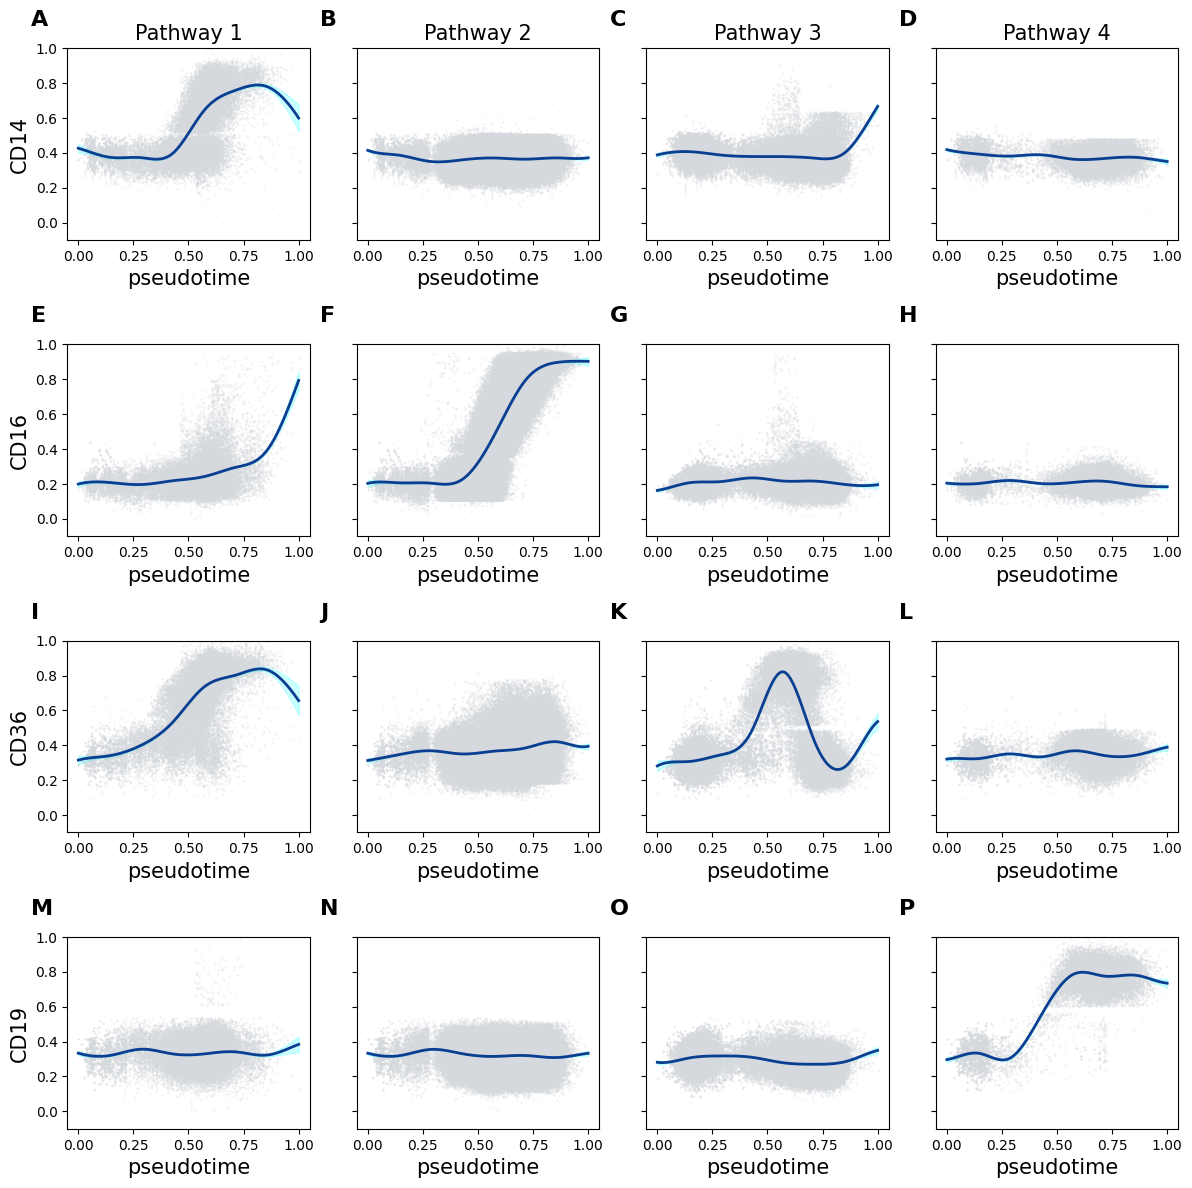

In [46]:
visualization_GAM_plots.marker_evolution_visualization_and_lineage_extraction(refined_pathway_groups,
                                                              markers=['CD14', 'CD16', 'CD36', 'CD19'],
                                                              output_folder='./results/P1/lineages-csv-files/')

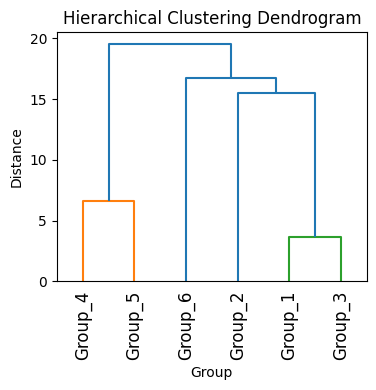

Threshold 0.10: Number of clusters = 6
Threshold 0.30: Number of clusters = 6
Threshold 0.50: Number of clusters = 6
Threshold 0.71: Number of clusters = 6
Threshold 0.91: Number of clusters = 6
Threshold 1.11: Number of clusters = 6
Threshold 1.31: Number of clusters = 6
Threshold 1.51: Number of clusters = 6
Threshold 1.72: Number of clusters = 6
Threshold 1.92: Number of clusters = 6
Threshold 2.12: Number of clusters = 6
Threshold 2.32: Number of clusters = 6
Threshold 2.52: Number of clusters = 6
Threshold 2.73: Number of clusters = 6
Threshold 2.93: Number of clusters = 6
Threshold 3.13: Number of clusters = 6
Threshold 3.33: Number of clusters = 6
Threshold 3.53: Number of clusters = 6
Threshold 3.74: Number of clusters = 5
Threshold 3.94: Number of clusters = 5
Threshold 4.14: Number of clusters = 5
Threshold 4.34: Number of clusters = 5
Threshold 4.54: Number of clusters = 5
Threshold 4.75: Number of clusters = 5
Threshold 4.95: Number of clusters = 5
Threshold 5.15: Number of

In [53]:
def get_top_10pct_cells_labeled(data_dict, pseudotime_col='pseudotime'):
    dfs = []
    for group, df in data_dict.items():
        cutoff = df[pseudotime_col].quantile(0.95)
        top_df = df[df[pseudotime_col] >= cutoff].copy()
        top_df['OriginalGroup'] = group
        dfs.append(top_df)
    return pd.concat(dfs, ignore_index=True)
from sklearn.preprocessing import StandardScaler

top_cells = get_top_10pct_cells_labeled(filtered_group_dfs)

X = top_cells.select_dtypes(include=[np.number])
X_scaled = StandardScaler().fit_transform(X)
features = top_cells.select_dtypes(include=[np.number]).drop(columns=['pseudotime'], errors='ignore')
groups = top_cells['OriginalGroup'].unique()
results = []

for feature in features.columns:
    data_by_group = [top_cells[top_cells['OriginalGroup'] == g][feature].values for g in groups]
    
    try:
        stat, pval = f_oneway(*data_by_group) 
    except:
        stat, pval = kruskal(*data_by_group)  

    results.append({'Feature': feature, 'F-stat': stat, 'p-value': pval})
    
result_df = pd.DataFrame(results)
result_df['adj_pval'] = result_df['p-value'] * len(result_df)  
result_df = result_df.sort_values('p-value')

# rank markers based on p-val, all markers will be eventually used
_, adj_pvals, _, _ = multipletests(result_df['p-value'], method='fdr_bh')
result_df['adj_pval_fdr'] = adj_pvals
significant_markers = result_df[result_df['adj_pval_fdr'] < 0.05]


top_features = significant_markers['Feature'].head(10)
top_features = significant_markers['Feature'].head(10)
top_markers = significant_markers.sort_values('adj_pval_fdr').head(50)['Feature'].tolist()

summary_stats = []

# summary statistics for terminal cells of each pathway
for group, group_df in top_cells.groupby('OriginalGroup'):
    stats = {'OriginalGroup': group}
    for feature in top_markers:
        values = group_df[feature].dropna()
        stats[f'{feature}_mean'] = values.mean()
        stats[f'{feature}_median'] = values.median()
        stats[f'{feature}_q25'] = values.quantile(0.25)
        stats[f'{feature}_q75'] = values.quantile(0.75)
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats).set_index('OriginalGroup')
scaler = StandardScaler()
X_summary = scaler.fit_transform(summary_df)

# linkage matrix for hierarchical clustering
Z = linkage(X_summary, method='ward')

# dendrogram and merges for different thresholds
plt.figure(figsize=(4,4))
dendrogram(Z, labels=summary_df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Group')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

thresholds = np.linspace(0.1, 10, 50)
# thresholds and compute silhouette scores
silhouette_scores = []

for t in thresholds:
    clusters = fcluster(Z, t=t, criterion='distance')
    n_clusters = len(set(clusters))
    n_samples = len(clusters)
    print(f"Threshold {t:.2f}: Number of clusters = {n_clusters}")
    
    if n_clusters > 1 and n_clusters < n_samples:
        score = silhouette_score(X_summary, clusters)
    else:
        score = np.nan
    silhouette_scores.append(score)

if all(np.isnan(silhouette_scores)):
    print("No valid clustering found in threshold range. Assigning singleton clusters (each group its own cluster).")
    # cluster IDs = 1..n_samples 
    summary_df['Cluster'] = range(1, len(summary_df) + 1)
else:
    best_idx = np.nanargmax(silhouette_scores)
    best_threshold = thresholds[best_idx]
    best_score = silhouette_scores[best_idx]
    final_clusters = fcluster(Z, t=best_threshold, criterion='distance')
    summary_df['Cluster'] = final_clusters
    print(f"Best distance threshold: {best_threshold:.3f}")
    print(f"Best silhouette score: {best_score:.3f}")

print("Cluster assignment for each group:")
print(summary_df[['Cluster']])


In [52]:
import pandas as pd

def merge_groups_by_cluster(summary_df, filtered_group_dfs):

    if summary_df.index.name == 'OriginalGroup':
        summary_df = summary_df.reset_index()

    cluster_to_groups = summary_df.groupby('Cluster')['OriginalGroup'].apply(list).to_dict()

    merged_dict = {}
    celltype_stats = {}

    for cluster, groups in cluster_to_groups.items():
        merged_df = pd.concat([filtered_group_dfs[group] for group in groups], axis=0)
        merged_df = merged_df.drop_duplicates()

        merged_dict[cluster] = merged_df

        counts = merged_df['Celltype'].value_counts()
        proportions = merged_df['Celltype'].value_counts(normalize=True)

        celltype_stats[cluster] = pd.DataFrame({
            'Count': counts,
            'Proportion': proportions
        })

    return merged_dict, celltype_stats

merged_dict, celltype_stats = merge_groups_by_cluster(summary_df, filtered_group_dfs)

for cluster, stats_df in celltype_stats.items():
    print(f"Cluster {cluster} Celltype counts and proportions:")
    print(stats_df)
    print()


Cluster 1 Celltype counts and proportions:
    Count  Proportion
m3  18690    0.594220
m2   7351    0.233714
n2   1717    0.054589
m1   1227    0.039011
n1    745    0.023686
e4    704    0.022383
e1    426    0.013544
e3    246    0.007821
n3    143    0.004546
b3     70    0.002226
e2     57    0.001812
n4     51    0.001621
b2     15    0.000477
b1     11    0.000350

Cluster 2 Celltype counts and proportions:
     Count  Proportion
n3  180448    0.475051
n4   99807    0.262754
n2   91040    0.239674
m2    3843    0.010117
m1    1551    0.004083
e4    1494    0.003933
n1    1095    0.002883
e1     491    0.001293
m3      37    0.000097
e2      29    0.000076
b1      12    0.000032
e3       3    0.000008

Cluster 3 Celltype counts and proportions:
    Count  Proportion
e4  28393    0.384985
e3  24036    0.325907
m1   5745    0.077897
n1   5220    0.070779
e1   5205    0.070575
m2   2099    0.028461
e2   1765    0.023932
b1    546    0.007403
m3    347    0.004705
n2    286    0.00387

### Saving metadata <a id="output"></a>
We save/load other relevant results/metadata in dictionaries.

In [ ]:
# save each pathway/lineage separately in a CSV file to use for visualization and marker dynamics modeling
# here we retain cell indices per lineage only for evaluation
# if a Celltype column does not exist set index below to False
# pseudotime below is not scaled in [0,1]

for i, pathway_dict in enumerate(refined_pathway_groups):
    for key, df in pathway_dict.items():
        filename = f"./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_{key}.csv"
        df.to_csv(filename, index=True)
        
# saving
with open('./results/P1/P1_cluster_cell_state_results.pkl', 'wb') as f:
    pickle.dump(cell_states_results, f)
    
with open('./results/P1/P1_backtracked_paths.pkl', 'wb') as f:
    pickle.dump(backtracked_paths, f)

with open('./results/P1/P1_cell_state_connections_and_overlaps.pkl', 'wb') as f:
    pickle.dump(connections, f)

with open('./results/P1/P1_intra_segment_wasserstein_distances_dict.pkl', 'wb') as f:
    pickle.dump(intra_segment_wasserstein_distances_dict, f)
    
with open('./results/P1/P1_path_costs.pkl', 'wb') as f:
    pickle.dump(path_costs, f)

with open('./results/P1/P1_pathways_without_celltypes.pkl', 'wb') as f:
    pickle.dump(refined_pathway_groups, f)
    
# example to load a dictionary
#with open('./results/P1/P1_path_costs.pkl', 'rb') as f:
#    path_costs = pickle.load(f)

In [ ]:
with open('./results/P1/P1_cluster_cell_state_results.pkl', 'wb') as f:
    pickle.dump(cell_states_results, f)
    
with open('./results/P1/P1_backtracked_paths.pkl', 'wb') as f:
    pickle.dump(backtracked_paths, f)

with open('./results/P1/P1_cell_state_connections.pkl', 'wb') as f:
    pickle.dump(connections, f)

with open('./results/P1/P1_intra_segment_wasserstein_distances_dict.pkl', 'wb') as f:
    pickle.dump(intra_segment_wasserstein_distances_dict, f)
    
with open('./results/P1/P1_inter_segment_wasserstein_distances_dict_dict.pkl', 'wb') as f:
    pickle.dump(inter_segment_wasserstein_distances_dict_dict, f)
    
with open('./results/P1/P1_path_costs.pkl', 'wb') as f:
    pickle.dump(path_costs, f)


In [5]:
# load results test
with open('./results/P1/P1_path_costs.pkl', 'rb') as f:
    path_costs = pickle.load(f)

# load results test
with open('./results/P1/P1_intra_segment_wasserstein_distances_dict.pkl', 'rb') as f:
    intra_segment_wasserstein_distances_dict = pickle.load(f)

with open('./results/P1/P1_cell_state_connections.pkl', 'rb') as f:
    connections = pickle.load(f)
    
with open('./results/P1/P1_backtracked_paths.pkl', 'rb') as f:
    backtracked_paths = pickle.load(f)
    
with open('./results/P1/P1_cluster_cell_state_results.pkl', 'rb') as f:
    cell_state_results = pickle.load(f)
    

### Evaluation <a id="evaluation"></a>
We compute the cell type proportions in each automatically inferred lineage/pathway using the ground truth cell type labels if available.

original_df = pd.read_csv("./datasets/P1_BM_pseudotime.csv")

lineage_1 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_1.csv")
lineage_2 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_2.csv")
lineage_3 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_3.csv")
lineage_4 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_4.csv")

#### extract cell indices in each lineage dataset and subset original dataset for these indices
lin_1_indices = lineage_1.iloc[:, 0].tolist()
lin_2_indices = lineage_2.iloc[:, 0].tolist()
lin_3_indices = lineage_3.iloc[:, 0].tolist()
lin_4_indices = lineage_4.iloc[:, 0].tolist()

evaluation_lin_1 = original_df.loc[lin_1_indices]
evaluation_lin_2 = original_df.loc[lin_2_indices]
evaluation_lin_3 = original_df.loc[lin_3_indices]
evaluation_lin_4 = original_df.loc[lin_4_indices]

print("Lineage 1")
print(evaluation_lin_1.Celltype.value_counts())
print("Lineage 2")
print(evaluation_lin_2.Celltype.value_counts())
print("Lineage 3")
print(evaluation_lin_3.Celltype.value_counts())
print("Lineage 4")
print(evaluation_lin_4.Celltype.value_counts())